# **Overview of MPOPT**
(c) 2021 Devakumar Thammisetty

MPOPT is an open-source Multi-phase Optimal Control Problem (OCP) solver based on pseudo-spectral collocation with customized adaptive grid refinement techniques.

Tip: Ctrl + Tab (For the documentation of commands/syntax)

Install mpopt from pypi using the following. Disable after first usage

In [1]:
#pip install mpopt

Import mpopt (Contains main solver modules)

In [2]:
from mpopt import mp

## Defining OCP

We first create an OCP object and then polulate the object with dynamics, path_constraints, terminal_constraints and objective (running_costs, terminal_costs)
* create an OCP object (Lets define moon-lander OCP)

In [3]:
ocp = mp.OCP(n_states=2, n_controls=1, n_phases=1)

* Add dynamics to the OCP. The solver being multi-phase, we add phase index to dynamics definition. 

#### Moon lander (2D)

$ \dot{x} = v; \quad \dot{v} = u - g$

* Using the standard Bolza form of OCP,
$\dot{x} = f(x, u, t) \quad \implies$

In [4]:
ocp.dynamics[0] = lambda x, u, t: [x[1], u[0] - 1.5]

* Add objective function, Lets get fuel optimal solution (u : Thrust level), Using standard Bolza form

$ J = 0 + \int_{t_0}^{t_f} u dt $

In [5]:
ocp.running_costs[0] = lambda x, u, t: u[0]

* Add terminal constraints. The target is to reach (postion : 0, velocity : 0), Using standard terminal constraints function

$h(x_f, t_f, x_0, t_0) = 0 $

In [6]:
ocp.terminal_constraints[0] = lambda xf, tf, x0, t0: [xf[0], xf[1]]

* Define starting position and initial velocity

$x[phase]$

In [7]:
ocp.x00[0] = [10.0, -2.0]

* Thrust is constrained between 0 and 3. 
$ \implies 0 \leq u \leq 3$

In [8]:
ocp.lbu[0], ocp.ubu[0] = 0, 3

* Validate if the ocp is well defined

In [9]:
ocp.validate()

### Solve and plot the results in one line

Lets solve the OCP using following pseudo-spectral approximation
* Collocation using Legendre-Gauss-Radau roots
* Global collocation (single segment)
* Let the polynomial be of degree 20 (Max.)
* Let's plot the position and velocity evolution with time starting from 0.

The OCP is a free final time formulation, 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Total number of variables............................:       62
                     variables with only lower bounds:        1
                variables with lower and upper bounds:       21
                     variables with only upper bounds:        0
Total number of equality constraints.................:       44
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:        0


Number of Iterations....: 32

    

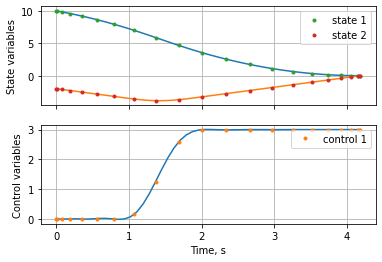

In [10]:
mpo, post = mp.solve(ocp, n_segments=1, poly_orders=20, scheme="LGR", plot=True)

The tics in the solution represent the values at collocation nodes. The states and controls are plotted by interpolating the lagrange polynomials at only 10 points in a single segment (by default). Let's interpolate with better resolution for plotting.

In [11]:
post._INTERPOLATION_NODES_PER_SEG = 200

Lets plot the same result again, this time the control profile is more refined. 

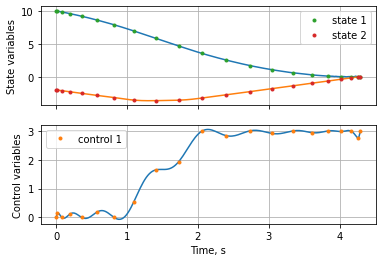

In [12]:
fig, axs = post.plot_phases()

Lets retrive the solution to see the terminal time

In [13]:
x, u, t = post.get_data()

Last element of t and x gives the terminal values. Exact terminal time from the analytical solution is 4.1641s.

In [14]:
print(f"Terminal time, state : {t[-1]}, {x[-1]}")

Terminal time, state : [4.29103151], [0. 0.]


The Fuel optimal solution to the moon-lander OCP is known to have bang-bang thrust profile. The selected OCP has one discontinuity. To better appoximate the solution, we can divide the domain into multiple segments.

Lets solve the problem now using better collocation approximation, based on the bang-nag nature of the thrust profile.
* Number of segments : 20
* Polynomials of degree : 3

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 133.00us (  4.75us) 135.34us (  4.83us)        28
       nlp_g  | 453.00us ( 16.18us) 439.85us ( 15.71us)        28
    nlp_grad  |  42.00us ( 42.00us)  27.40us ( 27.40us)         1
  nlp_grad_f  | 210.00us (  7.24us) 204.99us (  7.07us)        29
  nlp_hess_l  | 229.00us (  8.48us) 223.41us (  8.27us)        27
   nlp_jac_g  | 624.00us ( 21.52us) 629.43us ( 21.70us)        29
       total  |  50.55ms ( 50.55ms)  50.55ms ( 50.55ms)         1


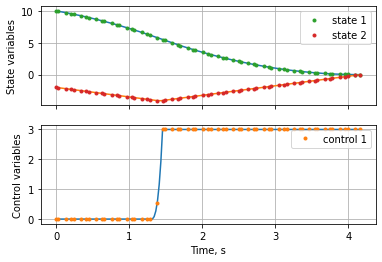

In [15]:
mpo, post = mp.solve(ocp, n_segments=20, poly_orders=3, scheme="LGR", plot=True)

The solution is now more refined. Lets look at the terminal time.

In [16]:
print(f"Terminal time, s : {post.get_data()[-1][-1][0]} vs 4.1641")

Terminal time, s : 4.164513728300107 vs 4.1641


Let's find the best solution by increasing the collocation nodes

In [17]:
mpo, post = mp.solve(ocp, n_segments=200, poly_orders=3, scheme="LGR", plot=False)
print(f"\nTerminal time, s : {post.get_data()[-1][-1][0]} vs 4.1641")

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 662.00us ( 16.55us) 676.35us ( 16.91us)        40
       nlp_g  |   4.25ms (106.15us)   4.22ms (105.47us)        40
    nlp_grad  | 952.00us (952.00us) 954.12us (954.12us)         1
  nlp_grad_f  |   1.48ms ( 38.00us)   1.47ms ( 37.71us)        39
  nlp_hess_l  |   1.77ms ( 47.76us)   1.77ms ( 47.71us)        37
   nlp_jac_g  |   6.94ms (177.90us)   6.94ms (178.06us)        39
       total  | 518.83ms (518.83ms) 518.30ms (518.30ms)         1

Terminal time, s : 4.164150730470345 vs 4.1641


Let's check how the Legendre-Gauss-Lobatto roots solve the OCP

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 919.00us ( 18.76us) 924.44us ( 18.87us)        49
       nlp_g  |   5.44ms (111.04us)   5.43ms (110.72us)        49
    nlp_grad  | 189.00us (189.00us) 188.91us (188.91us)         1
  nlp_grad_f  |   1.68ms ( 37.22us)   1.68ms ( 37.34us)        45
  nlp_hess_l  |   2.02ms ( 47.07us)   2.03ms ( 47.11us)        43
   nlp_jac_g  |   7.78ms (172.84us)   7.82ms (173.89us)        45
       total  | 635.01ms (635.01ms) 637.85ms (637.85ms)         1

Terminal time using Lobatto roots , s : 4.7234687943538125 vs 4.1641


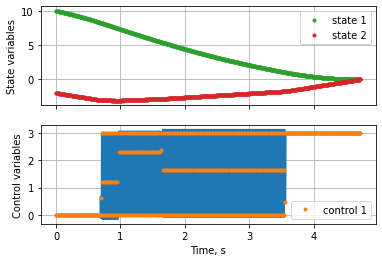

In [18]:
mpo, post = mp.solve(ocp, n_segments=200, poly_orders=3, scheme="LGL", plot=True)
print(f"\nTerminal time using Lobatto roots , s : {post.get_data()[-1][-1][0]} vs 4.1641")

Pretty bad result, huh!. The thrust profile is not smooth. Besides, so many number of segments. Lobatto roots lead to better convergence when the degree of the polynomial is higher.

### Adding additional constraints to the OCP

Let's constrain the derivative of control between $\pm 1$.

$-1 \leq \dot{u} \leq 1$

* Enable the differential constraint
* Choose bounds of the control slope

In [19]:
ocp.diff_u[0] = 1
ocp.lbdu[0], ocp.ubdu[0] = -1, 1

Let's solve again by adding the above constraint.

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 236.00us (  6.21us) 238.42us (  6.27us)        38
       nlp_g  |   2.14ms ( 56.32us)   2.13ms ( 55.97us)        38
    nlp_grad  | 100.00us (100.00us)  99.64us ( 99.64us)         1
  nlp_grad_f  | 358.00us (  9.18us) 355.98us (  9.13us)        39
  nlp_hess_l  | 447.00us ( 12.08us) 444.18us ( 12.00us)        37
   nlp_jac_g  |   3.27ms ( 83.87us)   3.29ms ( 84.37us)        39
       total  | 143.80ms (143.80ms) 143.80ms (143.80ms)         1

Terminal time using Lobatto roots , s : 4.211175721236632 vs 4.1641


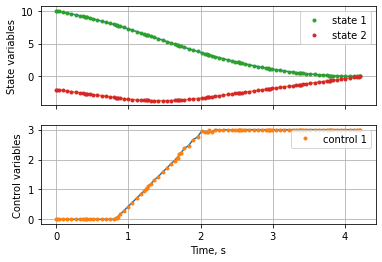

In [20]:
mpo, post = mp.solve(ocp, n_segments=10, poly_orders=10, scheme="LGL", plot=False)
post._INTERPOLATION_NODES_PER_SEG = 20
post.plot_phases()
print(f"\nTerminal time using Lobatto roots , s : {post.get_data()[-1][-1][0]} vs 4.1641")

Change the number of semgents and approximating to see how the solution behaves.

Disable the slope constraint for further calculations. Also, Radau roots are found to be approximating the given solution best!

In [21]:
ocp.diff_u[0] = 0

Let's see what happens if we increase the polynomial degree to 25.

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 183.00us (  3.73us) 175.48us (  3.58us)        49
       nlp_g  |   1.42ms ( 28.92us)   1.41ms ( 28.67us)        49
    nlp_grad  |  58.00us ( 58.00us)  58.84us ( 58.84us)         1
  nlp_grad_f  | 179.00us (  5.26us) 176.70us (  5.20us)        34
  nlp_hess_l  | 246.00us (  6.00us) 238.85us (  5.83us)        41
   nlp_jac_g  |   1.75ms ( 38.96us)   1.76ms ( 39.17us)        45
       total  |  65.25ms ( 65.25ms)  65.29ms ( 65.29ms)         1

Terminal time using Radau roots , s : 52.99261594434391 vs 4.1641


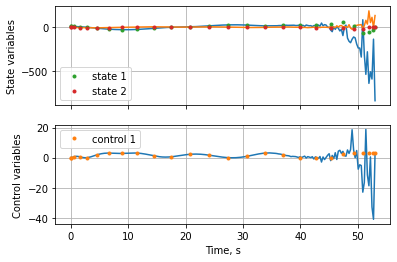

In [22]:
mpo, post = mp.solve(ocp, n_segments=1, poly_orders=25, scheme="LGR", plot=False)
post._INTERPOLATION_NODES_PER_SEG = 200
post.plot_phases()
print(f"\nTerminal time using Radau roots , s : {post.get_data()[-1][-1][0]} vs 4.1641")

OOPs! Solution diverged. 

The derivative operators is contructed using numpy's polynomial module. As the number of nodes increases, numerical noise builds up in the D matrix approximation leading to unstable solution. The solution can be improved by using exact derivative equations in collocation routine.

A good guess of the number of segments and polynomial order are necessary to get exact solution. However, adaptive grid refinement techniques solve this problem by relocating the collocation points.

## Adaptive grid refinement schemes

There are three inbuit refinement schemes in the package. First two are iterative. Refer theis for the exact details of implementaion.

The schemes are named as follows
* Adaptive_h_refinement (Iterative)
  * Scheme-1: Based on control slope
  * Scheme-2: Based on residual in dynamics
* Scheme-3: Direct optimization of segment widths (h)

Let's see how grid refinement changes the solution to moon-lander OCP

Let's create the optimizer object

In [23]:
mpo = mp.mpopt_h_adaptive(ocp, 10, 4) # Use ctrl + tab for help, inside ()

## Adaptive scheme-I

Let's solve the OCP using scheme 1. Let's limit the maximum iterations to 1. (Same as non-adaptive solution)

* control_slope

In [24]:
solution = mpo.solve(max_iter=1, mpopt_options={'method':'control_slope'})

Iteration : 1, None
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 170.00us (  4.25us) 172.65us (  4.32us)        40
       nlp_g  | 568.00us ( 14.20us) 554.04us ( 13.85us)        40
    nlp_grad  |  41.00us ( 41.00us)  41.23us ( 41.23us)         1
  nlp_grad_f  | 255.00us (  6.38us) 256.23us (  6.41us)        40
  nlp_hess_l  | 298.00us (  7.84us) 285.74us (  7.52us)        38
   nlp_jac_g  | 698.00us ( 17.45us) 704.14us ( 17.60us)        40
       total  |  49.50ms ( 49.50ms)  49.17ms ( 49.17ms)         1
Stopping the iterations: Iteration limit exceeded
Adaptive Iter., max_residual : 1, None


Let's process the solution and plot states and controls

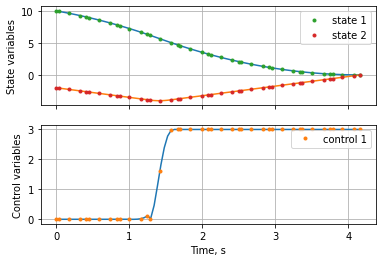

In [25]:
post = mpo.process_results(solution, plot=True)

Let's increase the number of iterations and see how the grid refinement works. Let's enable the residual plot as well.

Iteration : 1, None
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 214.00us (  5.35us) 218.79us (  5.47us)        40
       nlp_g  | 846.00us ( 21.15us) 821.79us ( 20.54us)        40
    nlp_grad  |  22.00us ( 22.00us)  21.94us ( 21.94us)         1
  nlp_grad_f  | 342.00us (  8.55us) 334.06us (  8.35us)        40
  nlp_hess_l  | 397.00us ( 10.45us) 391.31us ( 10.30us)        38
   nlp_jac_g  |   1.12ms ( 27.97us)   1.13ms ( 28.20us)        40
       total  |  59.08ms ( 59.08ms)  60.26ms ( 60.26ms)         1
Iteration : 2, 0.1635463119141526
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 113.00us (  4.91us) 111.43us (  4.84us)        23
       nlp_g  | 403.00us ( 17.52us) 393.41us ( 17.10us)        23
    nlp_grad  |  23.00us ( 23.00us)  22.35us ( 22.35us)         1
  nlp_grad_f  | 166.00us (  6.92us) 158.24us (  6.59us)        24
  nlp_hess_l  | 183.00us (  8.32us) 163.48us (  7.43us)        22
   nlp_jac_g  | 393.00

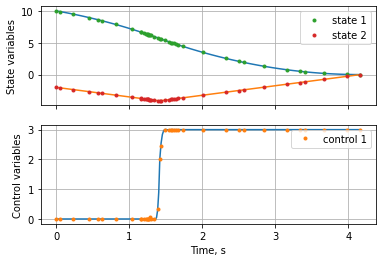

In [26]:
max_iter = 2
solution = mpo.solve(max_iter=max_iter, mpopt_options={'method':'control_slope'})
post = mpo.process_results(solution, plot=True)

Note that the grid is refine with more points towards the discontinuity in one iteration. Let's check the terminal time.

In [27]:
print(f"\nTerminal time using Adaptive +{max_iter-1} iteration , s : {post.get_data()[-1][-1][0]} vs 4.1641")


Terminal time using Adaptive +1 iteration , s : 4.164319735334812 vs 4.1641


Let's further increase the iterations and check the final result on convergence. 

Iteration : 1, None
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 190.00us (  4.75us) 190.71us (  4.77us)        40
       nlp_g  | 690.00us ( 17.25us) 672.37us ( 16.81us)        40
    nlp_grad  |  23.00us ( 23.00us)  22.63us ( 22.63us)         1
  nlp_grad_f  | 300.00us (  7.50us) 297.02us (  7.43us)        40
  nlp_hess_l  | 307.00us (  8.08us) 302.84us (  7.97us)        38
   nlp_jac_g  | 759.00us ( 18.98us) 766.46us ( 19.16us)        40
       total  |  52.73ms ( 52.73ms)  52.60ms ( 52.60ms)         1
Iteration : 2, 0.1635463119141526
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 115.00us (  5.00us) 115.55us (  5.02us)        23
       nlp_g  | 402.00us ( 17.48us) 386.89us ( 16.82us)        23
    nlp_grad  |  28.00us ( 28.00us)  27.71us ( 27.71us)         1
  nlp_grad_f  | 165.00us (  6.87us) 164.47us (  6.85us)        24
  nlp_hess_l  | 175.00us (  7.95us) 174.49us (  7.93us)        22
   nlp_jac_g  | 474.00

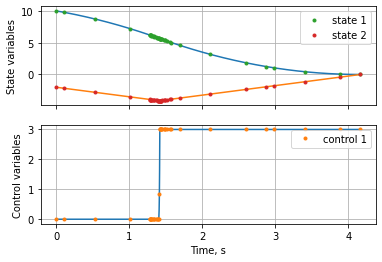

In [28]:
max_iter = 10
solution = mpo.solve(max_iter=max_iter, mpopt_options={'method':'control_slope'})
post = mpo.process_results(solution, plot=True)

In [29]:
print(f"\nTerminal time using Adaptive +{max_iter-1} iteration , s : {post.get_data()[-1][-1][0]} vs 4.1641")


Terminal time using Adaptive +9 iteration , s : 4.164145396779044 vs 4.1641


The solution converged in 3 iterations and terminal time matches to 4 th digit with 40 nodes.

## Adaptive scheme-II

The method is based on the estimates of residual at the mid points of the collocation nodes. Further, two sub-methods are implemented in the software

* residual based
  * merge/split
  * equal residual segments

Let's solve the same OCP using Adaptive scheme-II. This time let's enable the residual evolution plots.

In [30]:
mpo = mp.mpopt_h_adaptive(ocp, 10, 4) # Use ctrl + tab for help, inside ()
mpo.plot_residual_evolution = True

### Submethod-1: merge/split

Iteration : 1, None
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 223.00us (  5.57us) 218.39us (  5.46us)        40
       nlp_g  | 794.00us ( 19.85us) 778.30us ( 19.46us)        40
    nlp_grad  |  24.00us ( 24.00us)  23.54us ( 23.54us)         1
  nlp_grad_f  | 293.00us (  7.33us) 285.88us (  7.15us)        40
  nlp_hess_l  | 324.00us (  8.53us) 315.06us (  8.29us)        38
   nlp_jac_g  | 750.00us ( 18.75us) 756.61us ( 18.92us)        40
       total  |  56.11ms ( 56.11ms)  56.06ms ( 56.06ms)         1
Iteration : 2, 0.1635463119141526
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  69.00us (  4.31us)  70.27us (  4.39us)        16
       nlp_g  | 230.00us ( 14.38us) 225.34us ( 14.08us)        16
    nlp_grad  |  22.00us ( 22.00us)  21.39us ( 21.39us)         1
  nlp_grad_f  | 102.00us (  6.00us)  98.78us (  5.81us)        17
  nlp_hess_l  |  97.00us (  6.47us)  94.80us (  6.32us)        15
   nlp_jac_g  | 247.00

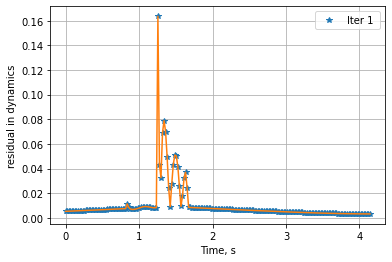

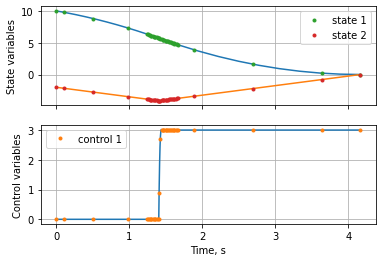

In [31]:
max_iter = 2
solution = mpo.solve(max_iter=max_iter, mpopt_options={'method':'residual', 'sub_method':'merge_split'})
post = mpo.process_results(solution, plot=True)

Notice that the residual in the first iteration is higher towards the discontinuity. In the second iteration, the segments near the start and final times merged so that segments close to the discontinuity are split and the solution converged with in +1 iteration. 

The solution is close to the exact solution, lets look at the terminal time.

In [32]:
print(f"\nTerminal time using Adaptive-II scheme with +{max_iter-1} iterations , s : {post.get_data()[-1][-1][0]} vs 4.1641")


Terminal time using Adaptive-II scheme with +1 iterations , s : 4.164161877944247 vs 4.1641


Lets reduce the tolerance on the residual to see if the solution improves

In [33]:
mpo = mp.mpopt_h_adaptive(ocp, 10, 4) # Use ctrl + tab for help, inside ()
mpo.plot_residual_evolution = True
mpo.tol_residual[0] = 1e-4

Iteration : 1, None
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 221.00us (  5.52us) 217.58us (  5.44us)        40
       nlp_g  | 777.00us ( 19.43us) 752.50us ( 18.81us)        40
    nlp_grad  |  24.00us ( 24.00us)  23.51us ( 23.51us)         1
  nlp_grad_f  | 317.00us (  7.93us) 312.16us (  7.80us)        40
  nlp_hess_l  | 363.00us (  9.55us) 355.37us (  9.35us)        38
   nlp_jac_g  | 910.00us ( 22.75us) 918.27us ( 22.96us)        40
       total  |  56.63ms ( 56.63ms)  56.56ms ( 56.56ms)         1
Adaptive Iter., max_residual : 1, 0.1635463119141526


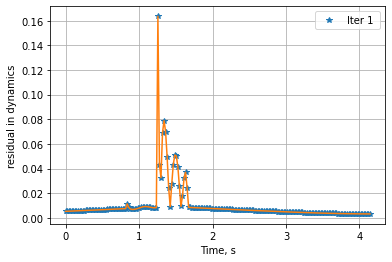

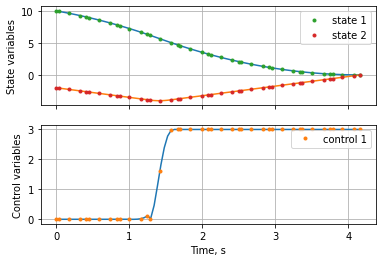

In [34]:
max_iter = 10
solution = mpo.solve(max_iter=max_iter, mpopt_options={'method':'residual', 'sub_method':'merge_split'})
post = mpo.process_results(solution, plot=True)

The solution doesn't change after 1st iteration because there is no segment that has residual lower than 1e-4. Residual threshold is a hyper parameters in this method. We can increase the number of segments for the method to work with strict tolerance.

### Submethod -2: Equal area segments

Iteration : 1, None
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 191.00us (  4.77us) 194.51us (  4.86us)        40
       nlp_g  | 658.00us ( 16.45us) 633.97us ( 15.85us)        40
    nlp_grad  |  23.00us ( 23.00us)  22.92us ( 22.92us)         1
  nlp_grad_f  | 283.00us (  7.08us) 278.84us (  6.97us)        40
  nlp_hess_l  | 317.00us (  8.34us) 310.54us (  8.17us)        38
   nlp_jac_g  | 748.00us ( 18.70us) 752.94us ( 18.82us)        40
       total  |  52.17ms ( 52.17ms)  51.94ms ( 51.94ms)         1
Iteration : 2, 0.1635463119141526
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 100.00us (  5.88us)  97.63us (  5.74us)        17
       nlp_g  | 289.00us ( 17.00us) 276.14us ( 16.24us)        17
    nlp_grad  |  44.00us ( 44.00us)  43.85us ( 43.85us)         1
  nlp_grad_f  | 133.00us (  7.39us) 130.74us (  7.26us)        18
  nlp_hess_l  | 140.00us (  8.75us) 136.25us (  8.52us)        16
   nlp_jac_g  | 359.00

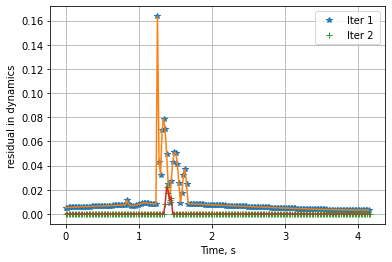

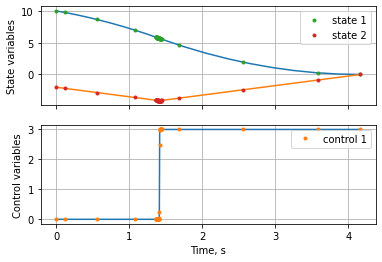

In [35]:
mpo = mp.mpopt_h_adaptive(ocp, 10, 4) # Use ctrl + tab for help, inside ()
mpo.plot_residual_evolution = True
max_iter = 3
solution = mpo.solve(max_iter=max_iter, mpopt_options={'method':'residual', 'sub_method':'equal_area'})
post = mpo.process_results(solution, plot=True)

Notice that the residual is reduced by concentrating the nodes close to the discontinuity.

The terminal free time in this case is given below

In [36]:
print(f"\nTerminal time using Adaptive-II scheme-2 with +{max_iter-1} iterations , s : {post.get_data()[-1][-1][0]} vs 4.1641")


Terminal time using Adaptive-II scheme-2 with +2 iterations , s : 4.164141831010297 vs 4.1641


## Adaptive schem-III : Direct optimization

The third scheme solves for the optimal segment widths along with the original OCP itself.
Hence, no iterative procedure is involved. 

For the moon lander problem with one disconitnuiy,one needs only 3 segments to get the exact thrust profile. Further, being bang bang profile, the thrust is constant at both corners. 

Let's use only 3 segments and minimum order polynomials to capture the solution to check the effectiveness of the method

Initialize the optimizer

In [37]:
mpo = mp.mpopt_adaptive(ocp, 3, 2) # Use ctrl + tab for help, inside ()
mpo.mid_residuals=True

Solve the NLP and process the results

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 707.00us (  3.23us) 713.84us (  3.26us)       219
       nlp_g  |   1.82ms (  8.33us)   1.75ms (  8.00us)       219
  nlp_grad_f  | 608.00us (  4.86us) 572.16us (  4.58us)       125
  nlp_hess_l  |   1.55ms ( 11.79us)   1.54ms ( 11.78us)       131
   nlp_jac_g  |   1.46ms ( 10.82us)   1.47ms ( 10.89us)       135
       total  | 123.35ms (123.35ms) 123.15ms (123.15ms)         1
Optimal segment width fractions: [0.32455921 0.02191577 0.65352503]


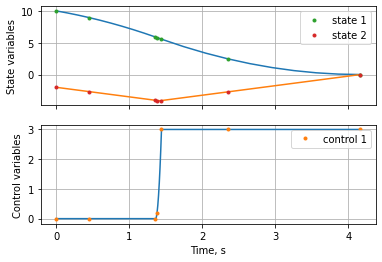

In [38]:
solution = mpo.solve()
post = mpo.process_results(solution, plot=True)

Notice that the middle segment width is 0.01. That is the default minimu width of the segment implemented in the method. Let's reduce the minimum allowed segment width to 1e-6 and resolve the problem.

In [39]:
mpo = mp.mpopt_adaptive(ocp, 3, 2) # Use ctrl + tab for help, inside ()
mpo.lbh[0] = 1e-6

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 171.00us (  2.85us) 170.49us (  2.84us)        60
       nlp_g  | 338.00us (  5.63us) 326.87us (  5.45us)        60
  nlp_grad_f  | 192.00us (  3.76us) 187.49us (  3.68us)        51
  nlp_hess_l  | 235.00us (  4.80us) 235.53us (  4.81us)        49
   nlp_jac_g  | 276.00us (  5.41us) 278.67us (  5.46us)        51
       total  |  28.92ms ( 28.92ms)  28.83ms ( 28.83ms)         1
Optimal segment width fractions: [3.39885715e-01 3.76903593e-05 6.60076594e-01]


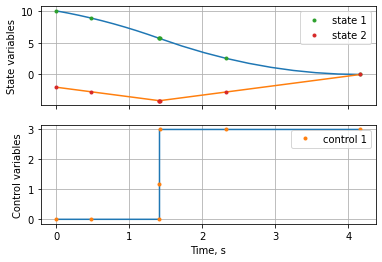

In [40]:
solution = mpo.solve()
post = mpo.process_results(solution, plot=True)

Notice that the discontinuity is exactly captured using the method with minimum possible collocation nodes.

In [41]:
print(f"\nTerminal time using Adaptive scheme-III , s : {post.get_data()[-1][-1][0]} vs 4.1641")


Terminal time using Adaptive scheme-III , s : 4.164140821803834 vs 4.1641


Let's check the robustness of the method by increasing the number of segments

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.35ms (  3.43us)   1.34ms (  3.39us)       394
       nlp_g  |   3.57ms (  9.06us)   3.54ms (  8.99us)       394
  nlp_grad_f  | 890.00us (  4.73us) 861.69us (  4.58us)       188
  nlp_hess_l  |   1.58ms (  7.60us)   1.56ms (  7.48us)       208
   nlp_jac_g  |   2.33ms ( 10.99us)   2.36ms ( 11.11us)       212
       total  | 235.80ms (235.80ms) 235.09ms (235.09ms)         1
Optimal segment width fractions: [3.39885635e-01 1.73867992e-05 1.79986954e-05 6.60077848e-01
 1.13168502e-06]


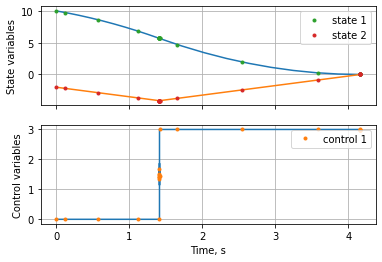

In [42]:
mpo = mp.mpopt_adaptive(ocp, 5, 4) # Use ctrl + tab for help, inside ()
mpo.lbh[0] = 1e-6
solution = mpo.solve()
post = mpo.process_results(solution, plot=True)

Notice that the time taken by the algorithm is significantly higher compared to iterative schemes. However, the solution is accurate using the Adaptive scheme-III.

## Conclusion

Using simple moon-lander test case OCP various features of the solver package in its current form are demonstrated. Notice that the OCP is defined only once in the beginning. This sheet can be used for all other OCP's merely by changing the OCP definition in the beginning.